# Enhancing Simulation with Wrappers and Decorators in Collimator
In this notebook, we demonstrate the convenience wrappers and decorators provided by Collimator. These powerful tools simplify the definition of dynamical systems, enabling users to create and simulate complex models with minimal boilerplate code. In particular, users may define custom bloks with Numpy-like interface.

In [1]:
import jax
import jax.numpy as jnp
from jax import lax

import collimator
from collimator import logging
from collimator.simulation import ODESolverOptions, SimulatorOptions

logging.set_log_level(logging.ERROR)
from collimator.library import *

from collimator.logging import logger

import matplotlib.pyplot as plt

### Creating ODE systems through the `ode_block` decorator

Consider a nonlinear ODE system of the following form:

$$
\mathbf{\dot{x}} = \mathbf{f}(t, \mathbf{x},\mathbf{u_1},\mathbf{u_2},\cdots,\mathbf{u_n})
$$

with full state output, i.e. $$
\mathbf{y} = \mathbf{x}.
$$

Such a system can be conveniently created by using the `@ode_block` decorator, without having to write a full `LeafSystem`. All we have to do is decorate a function returning $\mathbf{f}(t, \mathbf{x},\mathbf{u_1},\mathbf{u_2},\cdots,\mathbf{u_n})$ as follows:

```python
@ode_block(state_dim=2, num_inputs=n)
def my_func(time, state, inputs):
    # to evaluate f(x,u,t)
    # x is state.continuous state
    # (u1, u2, .. un) = inputs
    ode_rhs = ...
    return ode_rhs
```

#### Pendulum example

The following pendulum model dynamics is implemented in the code that follows:

\begin{equation}
\mathbf{\dot{x}} = 
\begin{bmatrix}
\dot{\theta} \\ \ddot{\theta}
\end{bmatrix} = 
\begin{bmatrix}
\omega \\ -\dfrac{g}{L} \sin(\theta) - \dfrac{b}{m L^2} \dot{\theta} +  \dfrac{u}{m L^2}
\end{bmatrix},
\end{equation}


Initialized callback pendulum:pendulum:input[0] with prereqs []
Initialized callback pendulum:pendulum_ode with prereqs [1, 2, 8]
Initialized callback pendulum:pendulum:output with prereqs [2]


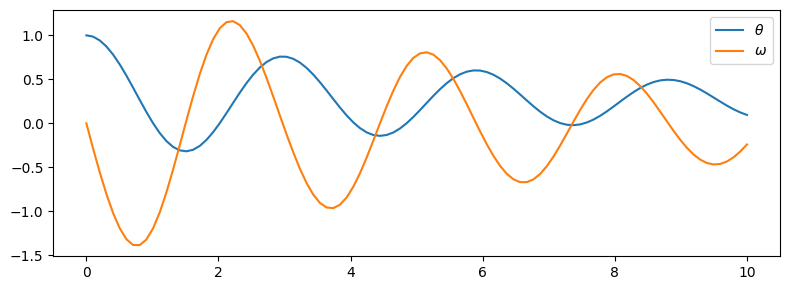

In [2]:
@ode_block(state_dim=2, num_inputs=1)
def pendulum(time, state, inputs):
    m = 2.0
    g = 9.8
    L = 2.0
    b = 2.0

    θ, dθ = state.continuous_state
    (u,) = inputs

    ddθ = -(g / L) * jnp.sin(θ) - b / m / L / L * dθ + u / m / L / L
    return jnp.array([dθ, ddθ])


x0 = jnp.array([1.0, 0.0])
pendulum.input_ports[0].fix_value(jnp.array([10.0]))
context = pendulum.create_context()
context = context.with_continuous_state(x0)

t = jnp.linspace(0.0, 10.0, 100)
x = collimator.odeint(
    pendulum,
    context,
    (t[0], t[-1]),
    t_eval=t,
    ode_options=ODESolverOptions(atol=1e-8, rtol=1e-6),
)

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(t, x[:, 0], label=r"$\theta$")
ax.plot(t, x[:, 1], label=r"$\omega$")
ax.legend()
fig.tight_layout()
plt.show()

### Creating Feedthrough blocks with `@feedthrough_block` decorator

The `@feedthrough_block` decorator enables the definition of simple input-output relationships, $y = f(x)$, without the need for explicitly creating and configuring blocks. An example of a block applying a feedthrough operation $y=ax +b $ to the output of the above created pendulum block is shown below.

Initialized callback offset_gain:u_0 with prereqs []
Initialized callback offset_gain:y_0 with prereqs [15]


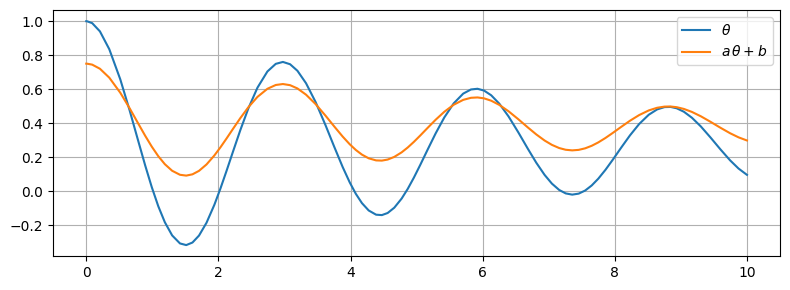

In [3]:
a = 0.5
b = 0.25


@feedthrough_block
def offset_gain(x):
    return a * x + b


builder = collimator.DiagramBuilder()
builder.add(pendulum, offset_gain)
builder.connect(pendulum.output_ports[0], offset_gain.input_ports[0])
diagram = builder.build()

x0 = jnp.array([1.0, 0.0])
context = diagram.create_context()
pendulum_context = context[pendulum.system_id].with_continuous_state(x0)
context = context.with_subcontext(pendulum.system_id, pendulum_context)

recorded_signals = {
    "pendulum": pendulum.output_ports[0],
    "offset_gain": offset_gain.output_ports[0],
}

options = SimulatorOptions(atol=1e-8, rtol=1e-6)

sol = collimator.simulate(
    diagram, context, (0.0, 10.0), options=options, recorded_signals=recorded_signals
)


t = sol.time
x = sol.outputs["pendulum"]
y = sol.outputs["offset_gain"]


fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(t, x[:, 0], label=r"$\theta$")
ax.plot(t, y[:, 0], label=r"$a\, \theta + b$")
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()